# <center>APRENDIZAJE SUPERVISADO (DengAI)<center>

---
# Resumen
---

En este trabajo, se probarán una serie de algoritmos de aprendizaje supervisado para la predicción de casos de dengue en dos ciudades. Antes de eso, se realizó una tarea de reexploración y selección de características, cuyos resultados fueron muy similares a los obtenidos en la práctica anterior. Posteriormente, se utilizaron varios algoritmos de aprendizaje automático con distintas complejidades. Cada uno presentó una serie de ventajas e inconvenientes. En este caso, los resultados más favorables correspondieron a los algoritmos más sencillos, ya que la complejidad de los otros dificultó la optimización de sus hiperparámetros. La técnica que obtuvo la mejor puntuación en la competición fue la de árboles de decisión. Intentamos seguir una metodología común en cada algoritmo para garantizar una mejor comparación.

En primer lugar, se instalan los paquetes necesarios para el desarrollo de la actividad, junto con las funciones para subir los datasets y darles a los outputs el formato necesario.

In [ ]:
# General
import time
import warnings
import io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, r2_score, silhouette_score
from scipy import cluster
from scipy.stats import randint, uniform
from scipy.cluster import hierarchy

In [ ]:
def upload_files (index_fields=None):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col = index_fields)

    return df

def download_predictions(test, pred_total_cases):
  file_name = "practica2_pred_" + time.strftime("%Y") + time.strftime("%m") + time.strftime("%d") + time.strftime("%H") + time.strftime("%M") + time.strftime("%S") + ".csv"
  predictions = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 'total_cases': pred_total_cases})
  with open(file_name, 'w') as f:
    predictions.to_csv(f, index = False)
  files.download(file_name)
  print("Downloaded " + file_name)

Se suben los conjuntos de entrenamiento, test y variable objetivo (train).

In [ ]:
#Subir el conjunto de entrenamiento sin variable objetivo (dengue_features_train.csv)
train_feat = upload_files()
print(train_feat.shape)
train_feat.head()

Saving dengue_features_train.csv to dengue_features_train (1).csv
User uploaded file "dengue_features_train (1).csv" with length 287139 bytes
(1456, 24)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [ ]:
#Subir la variable objetivo total_cases del conjunto de entrenamiento (dengue_labels_train.csv)
train_labels = upload_files()

#Unificar el conjunto de entrenamiento (características + variable objetivo)
train_raw = pd.merge(train_feat,train_labels,on=['city', 'year', 'weekofyear'])
print(train_raw.shape)
train_raw.head()

Saving dengue_labels_train.csv to dengue_labels_train (1).csv
User uploaded file "dengue_labels_train (1).csv" with length 19582 bytes
(1456, 25)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [ ]:
# Subir el conjunto de test sin variable objetivo (dengue_features_test.csv)
test_raw = upload_files()
print(test_raw.shape)
test_raw.head()

Saving dengue_features_test.csv to dengue_features_test (1).csv
User uploaded file "dengue_features_test (1).csv" with length 82465 bytes
(416, 24)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


---
# Reexploración
---

En este apartado, realizaremos un reanálisis de la exploración de datos realizada en la actividad anterior. Para ello, tomaremos en cuenta la variable objetivo. No se garantiza que se logre la mejor selección de características ni el mejor preprocesamiento; el objetivo es analizar los diferentes resultados y ganar experiencia en este tipo de proyectos. Primero, los datasets se guardan en variables que no se modificarán.

In [ ]:
train_feat_raw = pd.read_csv('dengue_features_train.csv')
train_labels_raw = pd.read_csv('dengue_labels_train.csv')
train_raw = pd.merge(train_feat_raw,train_labels_raw,on=['city', 'year', 'weekofyear'])
test_raw = pd.read_csv('dengue_features_test.csv')

In [ ]:
train= pd.merge(train_feat_raw,train_labels_raw,on=['city', 'year', 'weekofyear'])
test = pd.read_csv('dengue_features_test.csv')

La reexploración y la selección de características va a ser muy similar a la realizada en la práctica 1. En este proyecto se van a poner los apartados esenciales de limpieza de los datos, para no sobrecargar y repetir conceptos ya explicados anteriormente.

## Preprocesamiento y limpieza

En primera instancia, se eliminan las columnas que no van a ser útiles. Antes se binariza la varitable categórica *city*.

In [ ]:
#Binarización para la variable categórica city en los conjuntos de datos
lb = preprocessing.LabelBinarizer()
train['city_bin'] = lb.fit_transform(train['city'])
test['city_bin'] = lb.fit_transform(test['city'])
train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,city_bin
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4,1
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5,1
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4,1
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3,1
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6,1


In [ ]:
#Eliminación de la variable week_start_date por ser de tipo cadena de texto sin formato
train.drop("week_start_date", axis = 1, inplace = True)
test.drop("week_start_date", axis = 1, inplace = True)

#Eliminación de la variable city por ser texto y tener variable binzarizada
train.drop("city", axis = 1, inplace = True)
test.drop("city", axis = 1, inplace = True)

Puesto seguido se unifican las unidades de las magnitudes almacenadas como variables en los datasets. En este caso únicamente hay que transformar aquellas variables de temperatura que se presenten en K a celsius.

In [ ]:
#Se cambian las unidades de kelvil a celsius. Entrenamiento
train['reanalysis_air_temp_c'] = train['reanalysis_air_temp_k'] - 273.15
train['reanalysis_max_air_temp_c'] = train['reanalysis_max_air_temp_k'] - 273.15
train['reanalysis_min_air_temp_c'] = train['reanalysis_min_air_temp_k'] - 273.15
train['reanalysis_avg_temp_c'] = train['reanalysis_avg_temp_k'] - 273.15
train['reanalysis_dew_point_temp_c'] = train['reanalysis_dew_point_temp_k'] - 273.15
train['reanalysis_tdtr_c'] = train['reanalysis_tdtr_k']

#Se eliminan las que están en kelvin. Entrenamiento
train = train.drop(columns=['reanalysis_air_temp_k', 'reanalysis_max_air_temp_k',
                            'reanalysis_min_air_temp_k', 'reanalysis_avg_temp_k',
                            'reanalysis_dew_point_temp_k', 'reanalysis_tdtr_k'])

#Se cambian las unidades de kelvil a celsius. Test
test['reanalysis_air_temp_c'] = test['reanalysis_air_temp_k'] - 273.15
test['reanalysis_max_air_temp_c'] = test['reanalysis_max_air_temp_k'] - 273.15
test['reanalysis_min_air_temp_c'] = test['reanalysis_min_air_temp_k'] - 273.15
test['reanalysis_avg_temp_c'] = test['reanalysis_avg_temp_k'] - 273.15
test['reanalysis_dew_point_temp_c'] = test['reanalysis_dew_point_temp_k'] - 273.15
test['reanalysis_tdtr_c'] = test['reanalysis_tdtr_k']

#Se eliminan las que están en kelvin. Test
test = test.drop(columns=['reanalysis_air_temp_k', 'reanalysis_max_air_temp_k',
                            'reanalysis_min_air_temp_k', 'reanalysis_avg_temp_k',
                            'reanalysis_dew_point_temp_k', 'reanalysis_tdtr_k'])



Es importante recordar que la mayoría de las variables seguían una distribución normal, exceptuando aquellas que no podían adoptar valores negativos o las temporales (uniformes). Ahora, se comprobará el tipo de distribución de la variable objetivo.

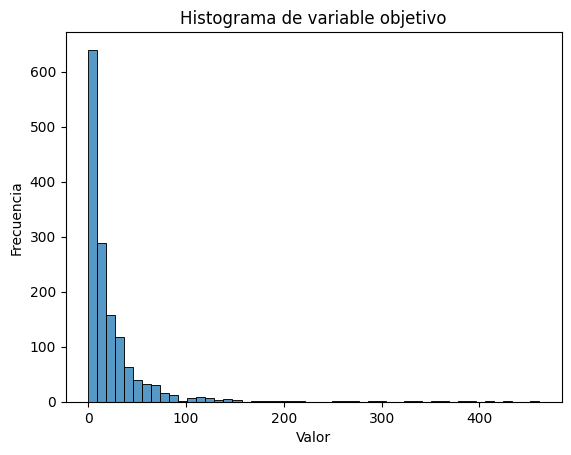

In [ ]:
#Mostrar histograma de la columna objetivo
sns.histplot(data=train, x= train.total_cases, bins=50)
plt.title(f'Histograma de variable objetivo')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.show()

En un principio la variable sigue algún tipo de distribución exponencial o de Xi-cuadrado, predominando valores más cercanos a 0.

A continuación, se sigue el mismo esquema de la actividad anterior de tratamiento de valores nulos. Se observa la cantidad de nulos de ambos datasets.

In [ ]:
#Valores nulos totales por variable
test.isnull().sum()
#train.isnull().sum()

year                                      0
weekofyear                                0
ndvi_ne                                  43
ndvi_nw                                  11
ndvi_se                                   1
ndvi_sw                                   1
precipitation_amt_mm                      2
reanalysis_precip_amt_kg_per_m2           2
reanalysis_relative_humidity_percent      2
reanalysis_sat_precip_amt_mm              2
reanalysis_specific_humidity_g_per_kg     2
station_avg_temp_c                       12
station_diur_temp_rng_c                  12
station_max_temp_c                        3
station_min_temp_c                        9
station_precip_mm                         5
city_bin                                  0
reanalysis_air_temp_c                     2
reanalysis_max_air_temp_c                 2
reanalysis_min_air_temp_c                 2
reanalysis_avg_temp_c                     2
reanalysis_dew_point_temp_c               2
reanalysis_tdtr_c               

El objetivo es, mediante un algoritmo de iteración, estimar los valores nulos faltantes en toda la distribución de datos. El proceso utilizado es el iterative imputer, cuyo funcionamiento se especificó en la actividad anterior.
Las referencias para aplicar este tipo de métodos de inferencia de nulos son:

https://cesarquezadab.com/2021/09/19/guia-sobre-tecnicas-de-imputacion-de-datos-con-python/
https://machinelearningmastery.com/handle-missing-data-python/


In [ ]:
#Algoritmo de iteración
imp = IterativeImputer(max_iter=10, random_state=0)


#Realizamos la imputación multivariada de regresión (train)
train2 = pd.DataFrame(imp.fit_transform(train), columns=train.columns)

#Realizamos la imputación multivariada de regresión (test)
test2 = pd.DataFrame(imp.fit_transform(test), columns=test.columns)

test2.shape

(416, 23)

Se observa que las magnitudes de la estadística descripitiva de ambos datasets no se modifican prácticamente antes y después de la imputación de nulos.

In [ ]:
train2.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,...,station_min_temp_c,station_precip_mm,total_cases,city_bin,reanalysis_air_temp_c,reanalysis_max_air_temp_c,reanalysis_min_air_temp_c,reanalysis_avg_temp_c,reanalysis_dew_point_temp_c,reanalysis_tdtr_c
count,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,...,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000
mean,2001.031593,26.503434,0.132100,0.128882,0.203540,0.202024,45.760388,40.149289,82.163027,45.760388,...,22.101395,39.392730,24.675137,0.642857,25.551749,30.278663,22.568117,26.075722,22.096333,4.905734
std,5.408314,15.019437,0.135725,0.118652,0.073405,0.083381,43.519806,43.285847,7.130910,43.519806,...,1.567496,47.201623,43.596000,0.479322,1.357864,3.232968,2.561151,1.257616,1.522568,3.546770
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,0.000000,57.787143,0.000000,...,14.700000,0.000000,0.000000,0.000000,21.485714,24.650000,13.750000,21.742857,16.492857,1.357143
25%,1997.000000,13.750000,0.040212,0.049217,0.155549,0.144718,9.960000,13.200000,77.226429,9.960000,...,21.100000,8.700000,5.000000,0.000000,24.515000,27.850000,20.750000,25.114286,20.980357,2.328571
50%,2002.000000,26.500000,0.112631,0.117033,0.195764,0.187957,38.710000,27.370000,80.369286,38.710000,...,22.200000,24.100000,12.000000,1.000000,25.498571,29.250000,23.050000,26.135714,22.475714,2.857143
75%,2005.000000,39.250000,0.231589,0.212943,0.247735,0.246914,70.047500,52.042500,86.041429,70.047500,...,23.300000,53.950000,28.000000,1.000000,26.677500,32.350000,24.750000,27.057143,23.306071,7.646429
max,2010.000000,53.000000,0.508357,0.454429,0.538314,0.546017,390.600000,570.500000,98.610000,390.600000,...,25.600000,543.300000,461.000000,1.000000,29.050000,40.850000,26.750000,29.778571,25.300000,16.028571


In [ ]:
train.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,...,station_min_temp_c,station_precip_mm,total_cases,city_bin,reanalysis_air_temp_c,reanalysis_max_air_temp_c,reanalysis_min_air_temp_c,reanalysis_avg_temp_c,reanalysis_dew_point_temp_c,reanalysis_tdtr_c
count,1456.000000,1456.000000,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,1446.000000,1443.000000,...,1442.000000,1434.000000,1456.000000,1456.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000
mean,2001.031593,26.503434,0.142294,0.130553,0.203783,0.202305,45.760388,40.151819,82.161959,45.760388,...,22.102150,39.326360,24.675137,0.642857,25.551852,30.277109,22.569156,26.075578,22.096356,4.903754
std,5.408314,15.019437,0.140531,0.119999,0.073860,0.083903,43.715537,43.434399,7.153897,43.715537,...,1.574066,47.455314,43.596000,0.479322,1.362420,3.234601,2.565364,1.261715,1.527810,3.546445
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,0.000000,57.787143,0.000000,...,14.700000,0.000000,0.000000,0.000000,21.485714,24.650000,13.750000,21.742857,16.492857,1.357143
25%,1997.000000,13.750000,0.044950,0.049217,0.155087,0.144209,9.800000,13.055000,77.177143,9.800000,...,21.100000,8.700000,5.000000,0.000000,24.508929,27.850000,20.750000,25.107143,20.968929,2.328571
50%,2002.000000,26.500000,0.128817,0.121429,0.196050,0.189450,38.340000,27.245000,80.301429,38.340000,...,22.200000,23.850000,12.000000,1.000000,25.496429,29.250000,23.050000,26.139286,22.490714,2.857143
75%,2005.000000,39.250000,0.248483,0.216600,0.248846,0.246982,70.235000,52.200000,86.357857,70.235000,...,23.300000,53.900000,28.000000,1.000000,26.683571,32.350000,24.750000,27.057143,23.310000,7.625000
max,2010.000000,53.000000,0.508357,0.454429,0.538314,0.546017,390.600000,570.500000,98.610000,390.600000,...,25.600000,543.300000,461.000000,1.000000,29.050000,40.850000,26.750000,29.778571,25.300000,16.028571


Tras comprobar que los resultados estadísticos son muy similares, se procede a eliminar los outliers, tal como se razonó en el trabajo anterior. Además, se recuerda que no hay valores duplicados.

Se va a usar la técnica basada en el análisis de componentes principales y se van a eliminar en 2% de datos que sean considerados más atípicos.

https://cienciadedatos.net/documentos/py21-deteccion-anomalias-pca-python

In [ ]:
#Estandarizar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train2)

#Aplicar PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

#Convertir los componentes principales a un DataFrame
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

#Calcular la distancia Mahalanobis para detectar outliers
mean = np.mean(principal_components, axis=0)
cov_matrix = np.cov(principal_components, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
mahalanobis_distances = np.apply_along_axis(lambda x: np.sqrt(np.dot(np.dot((x - mean).T, inv_cov_matrix), (x - mean))), 1, principal_components)

# Definir un umbral para identificar outliers (ejemplo: 95th percentile)
threshold = np.percentile(mahalanobis_distances, 98)
outliers = mahalanobis_distances > threshold

#Mostrar los outliers
outliers_df = train2[outliers]
#print("Outliers detectados:\n", outliers_df)

In [ ]:
#Se eliminan los outliers del conjunto de entrenamiento.
train3 = train2[~outliers]

## Selección de características

Para la selección de características, se presentará en primer lugar la matriz de correlaciones, teniendo en cuenta la variable objetivo.

<Axes: >

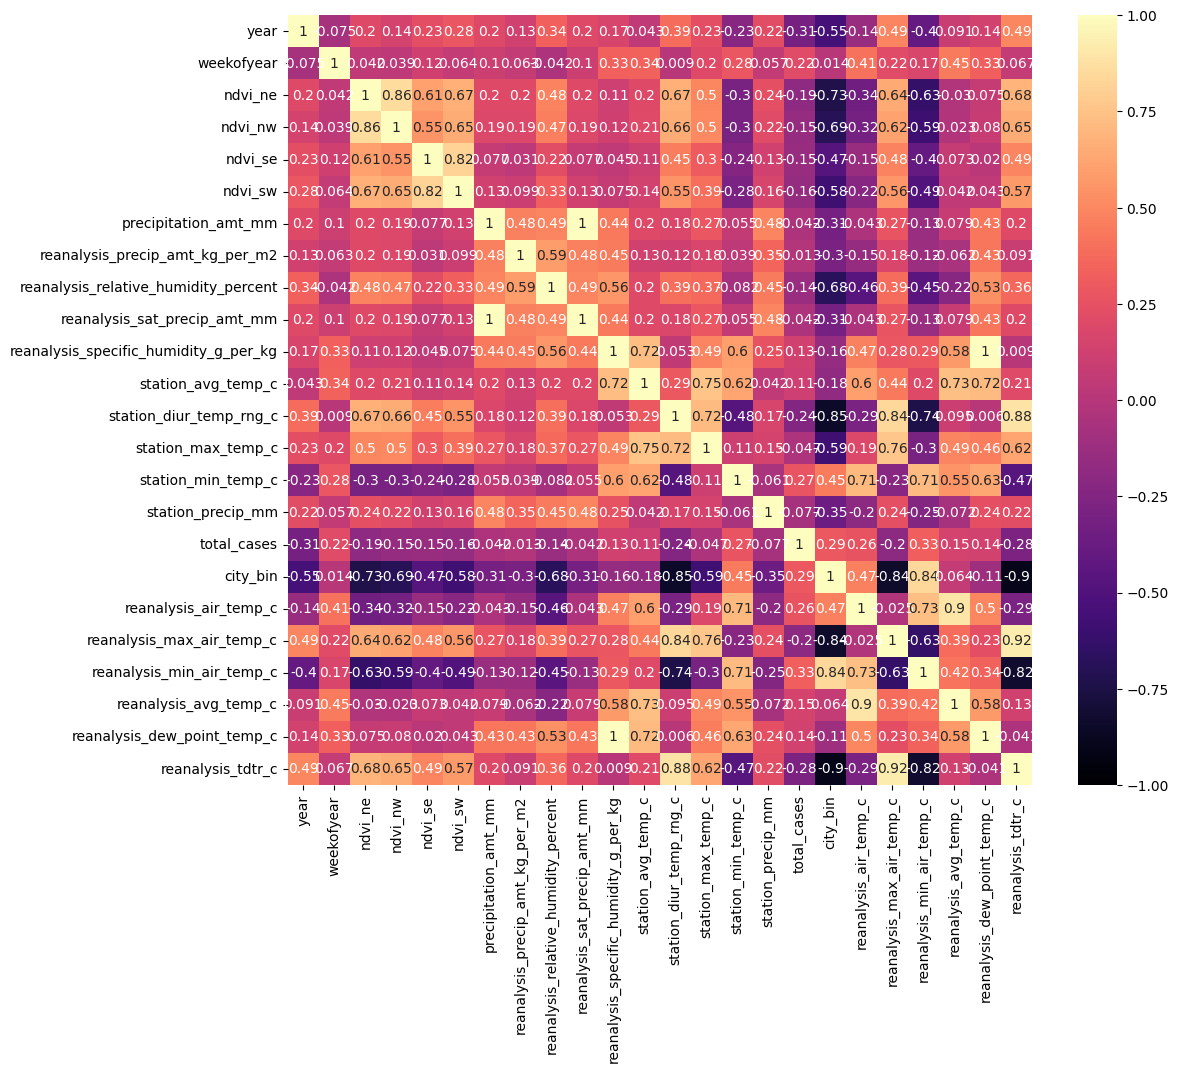

In [ ]:
#Matriz de correlaciones
plt.figure(figsize=(12, 10))
sns.heatmap(train3.corr(), vmin=-1, vmax=1, cmap='magma', annot=True)

La correlación de la variable objetivo con el resto es baja. Además, se observan dos pares de variables correlacionadas por la unidad, eligiéndose una característica de cada pareja para reducir la redundancia:


*   *precipitation_amt_mm* y *reanalysis_precip_amt_kg_per_m2*
*   *reanalysis_specific_humidity_g_per_kg* y *reanalysis_dew_point_temp_k*



In [ ]:
train4 = train3.drop(['reanalysis_precip_amt_kg_per_m2','reanalysis_dew_point_temp_c'], axis = 1)
test3 = test2.drop(['reanalysis_precip_amt_kg_per_m2','reanalysis_dew_point_temp_c'], axis = 1)

Como puede observarse, se sigue el mismo procedimiento que en la práctica anterior, pero ahora teniendo en cuenta la variable objetivo. Por lo tanto, se analizará cuál es el mejor número de clústers o características utilizando el algoritmo de KMeans y las técnicas de la curva de Elbow y la puntuación de silueta.

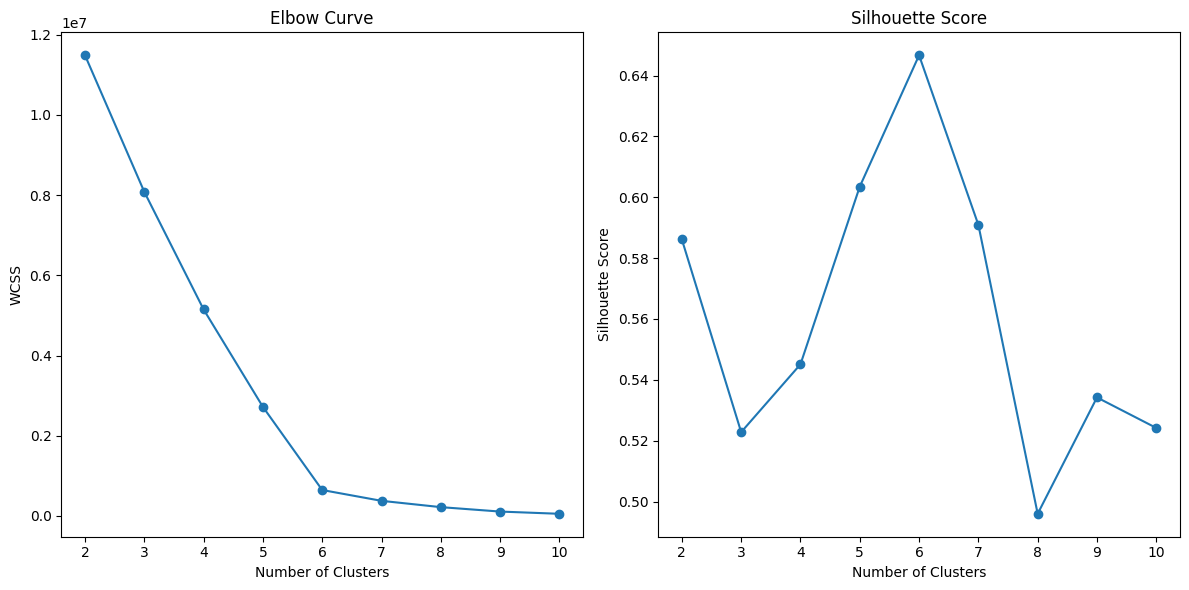

In [ ]:
warnings.filterwarnings("ignore")

def cluster_Wcss_Silhouette(data, k_max):
    wcss = []
    silhouette_scores = []

    for k in range(2, k_max + 1):
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=0)
        kmeans.fit(data)

        #Calcular WCSS (Within-Cluster Sum of Squares)
        wcss.append(kmeans.inertia_)

        #Calcular Silhouette score
        if k > 1:  # Silhouette score solo se calcula cuando hay más de un clúster
            labels = kmeans.labels_
            silhouette_avg = silhouette_score(data, labels)
            silhouette_scores.append(silhouette_avg)

    #Graficar Elbow Curve
    plt.figure(figsize=(12, 6))

    #WCSS
    plt.subplot(1, 2, 1)
    plt.plot(range(2, k_max + 1), wcss, marker='o')
    plt.title('Elbow Curve')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')

    #Silhouette Score
    plt.subplot(1, 2, 2)
    plt.plot(range(2, k_max + 1), silhouette_scores, marker='o')
    plt.title('Silhouette Score')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')

    plt.tight_layout()
    plt.show()

#Ejemplo de uso con train3.drop(columns=['year']).T y hasta 10 clústers
cluster_Wcss_Silhouette(train4.drop(columns=['year']).T, 10)

El número óptimo de características es claramente 6. Una hipótesis es que corresponden a las variables seleccionadas en el trabajo anterior, junto con la variable objetivo. Para aclarar las dudas, se aplica el algoritmo de clustering jerárquico.

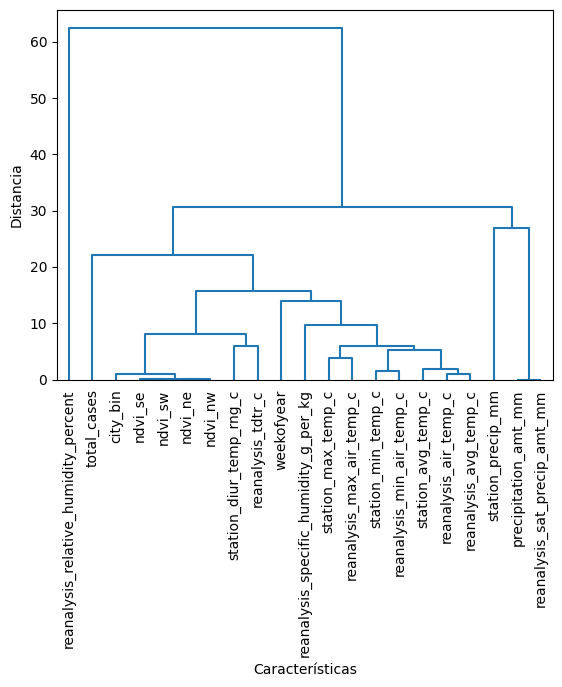

In [ ]:
warnings.filterwarnings("ignore")

#Matriz transpuesta para el análisis de las características
train_features = train4.drop(columns = 'year').T
names =  train_features.index

#Normalización de los datos
min_max_scaler = preprocessing.MinMaxScaler()
features_norm = min_max_scaler.fit_transform(train_features)

#Clustering jerárquico
dist = sklearn.metrics.DistanceMetric.get_metric('euclidean')
matdist= dist.pairwise(features_norm)
clusters = cluster.hierarchy.linkage(matdist, method = 'single')
cluster.hierarchy.dendrogram(clusters, color_threshold = 0, labels = names , leaf_rotation=90)
plt.xlabel('Características')
plt.ylabel('Distancia')
plt.show()

Una vez visto gráficamente los resultados del clustering, se presenta cada característica con el agrupamiento al que pertenece.

In [ ]:
#Supongamos que `clusters` es el resultado del clustering jerárquico
cut = 15  # Valor de corte ad-hoc
labels = hierarchy.fcluster(clusters, cut, criterion='distance')

#Obtener nombres de columnas de train3 sin la columna 'year'
column_names = train3.drop(columns=['year']).columns

#Mostrar cada columna con su label correspondiente
for col, label in zip(column_names, labels):
    print(f"Columna: {col} vs Label: {label}")

Columna: weekofyear vs Label: 2
Columna: ndvi_ne vs Label: 1
Columna: ndvi_nw vs Label: 1
Columna: ndvi_se vs Label: 1
Columna: ndvi_sw vs Label: 1
Columna: precipitation_amt_mm vs Label: 4
Columna: reanalysis_precip_amt_kg_per_m2 vs Label: 6
Columna: reanalysis_relative_humidity_percent vs Label: 4
Columna: reanalysis_sat_precip_amt_mm vs Label: 2
Columna: reanalysis_specific_humidity_g_per_kg vs Label: 2
Columna: station_avg_temp_c vs Label: 1
Columna: station_diur_temp_rng_c vs Label: 2
Columna: station_max_temp_c vs Label: 2
Columna: station_min_temp_c vs Label: 5
Columna: station_precip_mm vs Label: 3
Columna: total_cases vs Label: 1
Columna: city_bin vs Label: 2
Columna: reanalysis_air_temp_c vs Label: 2
Columna: reanalysis_max_air_temp_c vs Label: 2
Columna: reanalysis_min_air_temp_c vs Label: 2
Columna: reanalysis_avg_temp_c vs Label: 1


Las mejores características son las mismas que las escogidas en el anterior trabajo pero añadiendo una que pertenece al cluster de la variable objetivo: *station_diur_temp_rng_c*, *station_avg_temp_c*, *precipitation_amt_mm*, *station_precip_mm*, *reanalysis_relative_humidity_percent* y *station_min_temp_c*.

Finalmente, los datos se normalizan al principio. Si algún algoritmo lo requiere, se utilizarán los datos sin normalizar.

In [ ]:
selected_features = ['station_avg_temp_c','station_diur_temp_rng_c', 'precipitation_amt_mm', 'station_precip_mm', 'station_min_temp_c','reanalysis_relative_humidity_percent']
#Normalización con MinMaxScaler
scaler = MinMaxScaler()
X_train = train4[selected_features]
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(test3[selected_features])
y_train = train4['total_cases']

Con los datos normalizados, la limpieza y la selección de características, ya se puede llevar a cabo el conjunto de técnicas de aprendizaje automático para la predicción de la variable objetivo.

---
# Predicción
---

En este apartado, se utilizarán diversas técnicas de predicción basadas en Machine Learning. Al igual que se dejó claro en el apartado anterior, no se garantiza obtener los mejores resultados, sino extraer decisiones acertadas que sirvan de experiencia. En primera instancia, se define una función que redondea los resultados, sustituye los valores negativos por 0 y descarga el archivo CSV en el formato requerido para la competición.

In [ ]:
#Función que redondea y da la predicción en el formato deseado.

def red(y_prediction):
  y = np.rint(y_prediction) # round
  y = y.astype(int) # cast to int
  res = np.hstack(y)
  res[y_pred < 0] = 0
  return download_predictions(test_raw, res)

Se han elegido un total de cinco algoritmos distintos, junto con la regresión lineal de ejemplo, que no se tiene en cuenta en la competición. Posteriormente, se aplican técnicas de optimización de hiperparámetros para garantizar los mejores resultados de cada modelo. Siempre se sigue el mismo esquema de razonamiento.

## Regresión lineal

**Nombre del modelo:** "RL-Ejemplo" \
**Referencia:** ninguna

Este algoritmo sirve de ejemplo para ver como funciona la validación de la Web y el formato de salida de los resultados. No se va a tener en cuenta para la competición, aunque si se pondrá el resultado en la tabla final para tener un valor de referencia.

In [ ]:
#Ejecución del algoritmo de ML LinearRegression y generación de su modelo
model = linear_model.LinearRegression()

model.fit(X_train, y_train)

#Predicción sobre el conjunto de test
y_pred = model.predict(X_test)
formatted_y_pred = np.around(y_pred, decimals=4)
formatted_y_pred

array([ 26.9195,  32.4635,  33.7082,  46.0656,  36.5757,  50.5566,
        39.7249,  45.4492,  47.6991,  55.5703,  43.422 ,  56.7998,
        47.5428,  51.718 ,  46.6148,  51.6686,  53.9349,  52.6248,
        51.6581,  43.3596,  44.0174,  39.1302,  39.0821,  47.052 ,
        36.7929,  40.9313,  45.0436,  42.1325,  41.0226,  36.9707,
        37.1651,  25.9152,  31.0693,  31.3148,  24.3129,  35.59  ,
        23.4122,  29.5103,  27.3652,  26.4563,  27.9035,  22.9846,
        26.5649,  24.2938,  25.198 ,  33.854 ,  28.1932,  20.8429,
        27.845 ,  26.9612,  30.7215,  28.5436,  34.464 ,  35.6442,
        39.6864,  36.746 ,  40.7766,  43.1081,  39.665 ,  42.4721,
        44.5973,  54.9697,  49.2953,  58.0461,  53.1032,  51.9564,
        57.0428,  48.8041,  52.1024,  59.6772,  49.2981,  52.6288,
        50.4758,  46.3042,  56.0135,  57.5626,  58.3134,  48.9529,
        51.216 ,  49.6562,  41.989 ,  37.0132,  36.4462,  36.2227,
        39.5516,  35.8232,  36.1502,  35.1897,  29.0448,  19.8

Se ve que la función de redondeo funciona correctamente:

In [ ]:
red(y_pred)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded practica2_pred_20240710171441.csv


## K-Nearest Neighbors

**Nombre del modelo:** "KNN" \

En primera instancia, se busca usar este algoritmo básico para probar los resultados de manera inicial. Se utilizarán los datos normalizados, ya que KNN generalmente funciona mejor con esta metodología. Este algoritmo es más efectivo en espacios de pocas dimensiones y tamaños moderados, condiciones que se cumplen en este problema. Además, la eliminación de outliers busca mejorar el rendimiento de estas técnicas, que suelen fallar más a medida que aumenta el número de valores atípicos.

En primer lugar, se realiza validación cruzada para calcular el MAE y estimar un número inicial óptimo de vecinos y tipo de peso (principales hiperparámetros).

Min Value uniform: 20.41346019556546 (n_neighbors=74)
Min Value distance: 20.409660477826975 (n_neighbors=74)


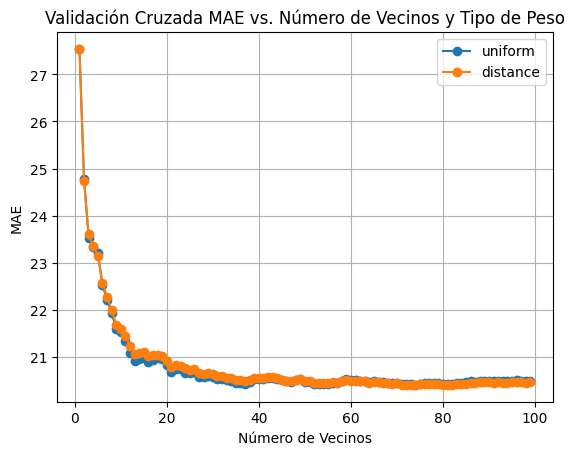

In [ ]:
#Dividir el conjunto de datos en características (X) y variable objetivo (y)
X = X_train
y = y_train
#Crear el objeto de KFold para la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#Definir diferentes valores de vecinos y pesos
n_neighbors_list = range(1, 100)
weights_list = ['uniform', 'distance']

total_scores = {weight: [] for weight in weights_list}

#Bucle para iterar sobre diferentes pesos
for weights in weights_list:
    for n_neighbors in n_neighbors_list:
        knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)

        #Realizar validación cruzada
        fold_scores = cross_val_score(knn, X, y, cv=kf, scoring='neg_mean_absolute_error')

        #Convertir puntuaciones a MAE positivo y guardar el promedio
        avg_mae = -np.mean(fold_scores)
        total_scores[weights].append(avg_mae)

#Graficar el MAE promedio en función del número de vecinos para cada tipo de peso
for weights, scores in total_scores.items():
    plt.plot(n_neighbors_list, scores, marker='o', label=weights)
    print(f'Min Value {weights}: {min(scores)} (n_neighbors={np.argmin(scores) + 1})')

plt.xlabel('Número de Vecinos')
plt.ylabel('MAE')
plt.title('Validación Cruzada MAE vs. Número de Vecinos y Tipo de Peso')
plt.legend()
plt.grid(True)
plt.show()


Se puede observar que el número óptimo de vecinos se podría encontrar entre 55 y 80 de manera muy aproximada.

**Optimización de hiperparámetros**

Se va a seguir la misma lógica en todos los algoritmos restantes:
1. Usar RandomSearch para llevar a cabo una estimación inicial de los mejores hiperparámetros.
2. Precisar más los resultados con la técnica de GridSearch.

**RandomSearch**

In [ ]:
#Definir el modelo
knn_regressor = KNeighborsRegressor()

#Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'n_neighbors': randint(15,65),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

#Configurar Randomized Search
random_search = RandomizedSearchCV(
    estimator=knn_regressor,
    param_distributions=param_dist,
    n_iter=500,  # Número de combinaciones a probar
    cv=5,        # Número de folds en la validación cruzada
    scoring='neg_mean_absolute_error',  # Métrica para evaluar
    random_state=42,
    n_jobs=-1    # Usar todos los núcleos disponibles
)

#Ajustar el modelo
random_search.fit(X_train, y_train)

#Mejor combinación de parámetros
print("Mejores parámetros encontrados:", random_search.best_params_)
print("Mejor puntuación obtenida (neg_mean_squared_error):", random_search.best_score_)


Mejores parámetros encontrados: {'metric': 'euclidean', 'n_neighbors': 62, 'weights': 'distance'}
Mejor puntuación obtenida (neg_mean_squared_error): -21.91031071555698


Una vez encontrados los mejores parámetros del RandomSearch, se aumenta la precisión de los resultados con GridSearch acotando más el intervalo de prueba.

In [ ]:
#Definir el modelo
knn_regressor = KNeighborsRegressor()

#Definir el espacio de búsqueda de hiperparámetros con n_neighbors entre 58 y 68
param_grid = {
    'n_neighbors': [40,59,60,61,62,63,64,65,66,67,68],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

#Configurar Grid Search con MAE negativo como métrica de evaluación
grid_search = GridSearchCV(
    estimator=knn_regressor,
    param_grid=param_grid,
    cv=5,        # Número de folds en la validación cruzada
    scoring='neg_mean_absolute_error',  # Métrica para evaluar
    n_jobs=-1    # Usar todos los núcleos disponibles
)

#Ajustar el modelo
grid_search.fit(X_train, y_train)

#Mejor combinación de parámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)
print("Mejor puntuación obtenida (neg_mean_absolute_error):", grid_search.best_score_)

Mejores parámetros encontrados: {'metric': 'euclidean', 'n_neighbors': 62, 'weights': 'distance'}
Mejor puntuación obtenida (neg_mean_absolute_error): -21.91031071555698


Se utilizan los resultados de esta técnica de optimización, ya que se considera más precisa que la anterior.

Mejores parámetros encontrados: {'metric': 'euclidean', 'n_neighbors': 62, 'weights': 'distance'} \
Mejor puntuación obtenida (neg_mean_absolute_error): -21.91031071555698 \

In [ ]:
#Crear el modelo con los mejores parámetros encontrados
best_knn_regressor = KNeighborsRegressor(
    n_neighbors=grid_search.best_params_['n_neighbors'],
    weights=grid_search.best_params_['weights'],
    metric=grid_search.best_params_['metric']
)

#Ajustar el modelo con los datos de entrenamiento completos
best_knn_regressor.fit(X_train, y_train)

y_pred = best_knn_regressor.predict(X_test)
red(y_pred)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded practica2_pred_20240710143317.csv


## Árboles de decisión


**Nombre del modelo:** "AD" \

Como siguiente algoritmo, se elige otro gran pilar del aprendizaje automático: el árbol de decisión. Esta técnica presenta una gran robustez frente a los valores atípicos y en la distribución de características. El problema del sobreajuste se controla utilizando validación cruzada en las técnicas de optimización de hiperparámetros. Se ha optado por utilizar los datos no normalizados, ya que en otras pruebas la normalización condujo a peores resultados.

In [ ]:
X_train = train4[selected_features]
X_test = test3[selected_features]
y_train = train4['total_cases']

Dado que se utilizarán algoritmos más complejos de la familia de los árboles de decisión, no se realizará una selección inicial de hiperparámetros con validación cruzada. El algoritmo se ejecutará primero y, posteriormente, se llevará a cabo una optimización más completa.

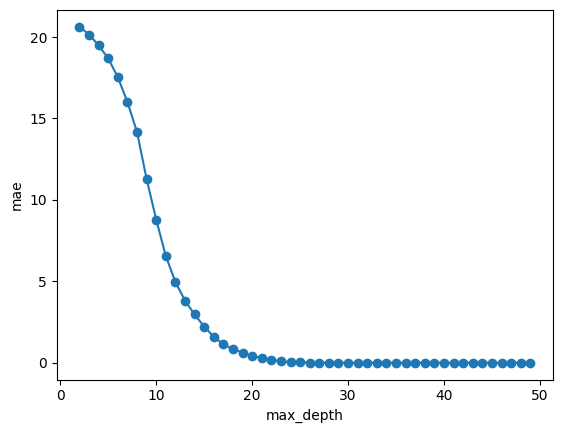

In [ ]:
#Compute the max
mae = []

for i in range(2, 50):
    regressor = DecisionTreeRegressor(max_depth=i)
    regressor.fit(X_train, y_train)
    pred_values = regressor.predict(X_train)
    maev = mean_absolute_error(y_train,pred_values)
    mae.append(maev)

#Plot mae
plt.plot(range(2,50), mae, marker='o')
plt.xlabel('max_depth')
plt.ylabel('mae')
plt.show()

Este resultado no debe tenerse en cuenta ya que puede conllevar a sobreajuste, por lo que se aplica la técnica de RandomSearch con una cantidad considerable de iteraciones para despúes encontrar un resultado más preciso con Grid Search:

**Optimización de hiperparámetros**

**Random Search**

In [ ]:
#Definir el modelo
tree_regressor = DecisionTreeRegressor()

#Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'max_depth': randint(2,10),  #Rango de profundidad del árbol
    'min_samples_split': randint(2, 20),  #Rango de min_samples_split
    'min_samples_leaf': randint(1, 20),   #Rango de min_samples_leaf
    'max_features': ['auto', 'sqrt', 'log2', None]  #Opciones para max_features
}

#Configurar Randomized Search con MAE como métrica de evaluación
random_search = RandomizedSearchCV(
    estimator=tree_regressor,
    param_distributions=param_dist,
    n_iter=500,  #Número de combinaciones a probar
    cv=5,        #Número de folds en la validación cruzada
    scoring='neg_mean_absolute_error',  # Métrica para evaluar
    random_state=421,
    n_jobs=-1    #Usar todos los núcleos disponibles
)

#Ajustar el modelo
random_search.fit(X_train, y_train)

#Mejor combinación de parámetros
print("Mejores parámetros encontrados:", random_search.best_params_)
print("Mejor puntuación obtenida (neg_mean_absolute_error):", random_search.best_score_)

Mejores parámetros encontrados: {'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 18, 'min_samples_split': 12}
Mejor puntuación obtenida (neg_mean_absolute_error): -21.211631263522424


**Grid Search**

In [ ]:
#Definir el modelo
tree_regressor = DecisionTreeRegressor()

#Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'max_depth': range(2,20,1),  #Ajustado según el mejor valor obtenido en validación cruzada
    'min_samples_split': range(5,20,1),  #Ajustar según necesidad
    'min_samples_leaf': range(5,20,1),   #Ajustar según necesidad
    'max_features': ['sqrt']
}

#Configurar Grid Search con MAE como métrica de evaluación
grid_search = GridSearchCV(
    estimator=tree_regressor,
    param_grid=param_grid,
    cv=5,        # Número de folds en la validación cruzada
    scoring='neg_mean_absolute_error',  # Métrica para evaluar
    n_jobs=-1    # Usar todos los núcleos disponibles
)

#Ajustar el modelo
grid_search.fit(X_train, y_train)

#Mejor combinación de parámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)
print("Mejor puntuación obtenida (neg_mean_absolute_error):", grid_search.best_score_)

Mejores parámetros encontrados: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 13, 'min_samples_split': 8}
Mejor puntuación obtenida (neg_mean_absolute_error): -20.972452304360086


De las numerosas pruebas que se han hecho, el mejor resultado obtenido es: 

Mejores parámetros encontrados: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 13, 'min_samples_split': 8}

Mejor puntuación obtenida (neg_mean_absolute_error): -21.1219

Se crea el modelo con los mejores parámetros y se descargan los resultados:

In [ ]:
#Crear el modelo con los mejores parámetros encontrados
best_tree_regressor = DecisionTreeRegressor(
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    max_features=grid_search.best_params_['max_features']
)

#Ajustar el modelo con los datos de entrenamiento completos
best_tree_regressor.fit(X_train, y_train)

#Realizar predicciones en el conjunto de prueba
y_pred = best_tree_regressor.predict(X_test)
red(y_pred)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded practica2_pred_20240710143944.csv


## Conjunto de modelos

**Nombre del modelo:** "CM" 

Ahora se utiliza un algoritmo más complejo y completo que los árboles de decisión: el conjunto de modelos. En este caso, se presenta el RandomForest, que pertenece a la familia de los árboles de decisión y cuya precisión y tolerancia al sobreajuste son mucho mayores que las de su antecesor.

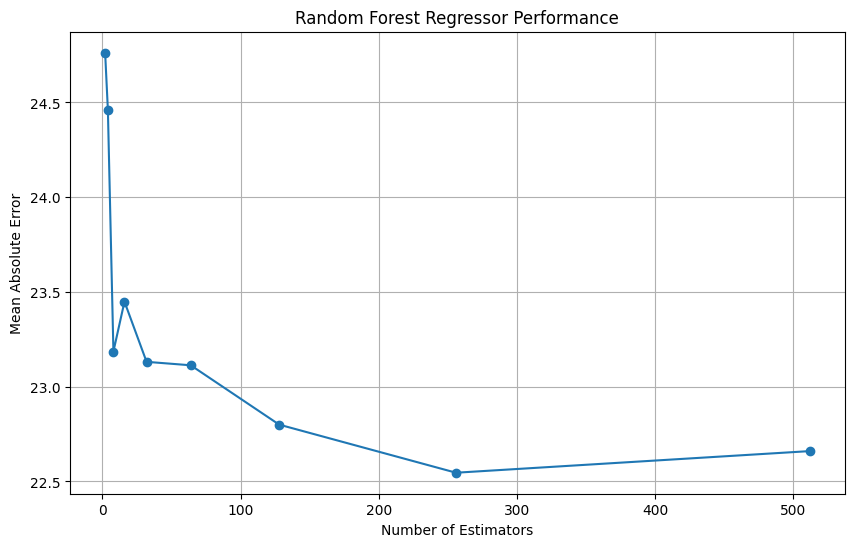

Estimators=2: Mean Absolute Error=24.762237762237763
Estimators=4: Mean Absolute Error=24.458916083916083
Estimators=8: Mean Absolute Error=23.185751748251747
Estimators=16: Mean Absolute Error=23.448863636363637
Estimators=32: Mean Absolute Error=23.131337412587413
Estimators=64: Mean Absolute Error=23.11306271853147
Estimators=128: Mean Absolute Error=22.799948098776223
Estimators=256: Mean Absolute Error=22.546226234702797
Estimators=512: Mean Absolute Error=22.660282588505243


In [ ]:
#Define the number of estimators (trees) to try
l_estimators = [2, 4, 8, 16, 32, 64, 128, 256, 512]

#Initialize an empty list to store the mean absolute errors (MAEs) for each number of estimators
total_scores = []

#Assuming you have already defined X and y

#Splitting the data into training and testing sets
X_train_part, X_test_part, y_train_part, y_test_part = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

for estimators in l_estimators:
    #Initialize the RandomForestRegressor with the current number of estimators
    regressor = RandomForestRegressor(n_estimators=estimators, criterion='absolute_error', random_state=0)

    #Train the model on the training data
    regressor.fit(X_train_part, y_train_part)

    #Predict using the testing data
    y_pred = regressor.predict(X_test_part)

    #Evaluate the model using mean absolute error (MAE)
    mae = mean_absolute_error(y_test_part, y_pred)

    #Append the MAE to the list
    total_scores.append(mae)

#Plotting the results (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(l_estimators, total_scores, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Absolute Error')
plt.title('Random Forest Regressor Performance')
plt.grid(True)
plt.show()

#Optionally, print the results
for i, estimators in enumerate(l_estimators):
    print(f"Estimators={estimators}: Mean Absolute Error={total_scores[i]}")


In [ ]:
best_est = l_estimators[np.argmin(total_scores)]
best_mae = min(total_scores)
print ("Min Value (estimators = %i, MAE = %6.2f)"  % (best_est, best_mae))

Min Value (estimators = 256, MAE =  22.55)


**Optimización de hiperparámetros**

**Random Search**

Para ahorrar tiempos de ejecución se elige la opción de 256 estimadores. Se busca mejorar los resultados iniciales de la validación cruzada antes representados.

In [ ]:
#Definir el modelo
forest_regressor = RandomForestRegressor()

#Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'n_estimators': [256],  # Número de árboles en el bosque
    'max_depth': randint(2, 20),  # Rango de profundidad del árbol
    'min_samples_split': randint(2, 20),  # Rango de min_samples_split
    'min_samples_leaf': randint(1, 20),  # Rango de min_samples_leaf
    'max_features': ['auto', 'sqrt', 'log2', None]  # Opciones para max_features
}

#Configurar Randomized Search con MAE como métrica de evaluación
random_search = RandomizedSearchCV(
    estimator=forest_regressor,
    param_distributions=param_dist,
    n_iter=20,  # Número de combinaciones a probar
    cv=5,  # Número de folds en la validación cruzada
    scoring='neg_mean_absolute_error',  # Métrica para evaluar
    random_state=421,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

#Ajustar el modelo
random_search.fit(X_train, y_train)

#Mejor combinación de parámetros
print("Mejores parámetros encontrados:", random_search.best_params_)
print("Mejor puntuación obtenida (neg_mean_absolute_error):", random_search.best_score_)


Mejores parámetros encontrados: {'max_depth': 18, 'max_features': 'log2', 'min_samples_leaf': 18, 'min_samples_split': 2, 'n_estimators': 256}
Mejor puntuación obtenida (neg_mean_absolute_error): -22.329544643643313


Finalmente, el mejor resultado ha sido: \
Mejores parámetros encontrados: {'max_depth': 18, 'max_features': 'log2', 'min_samples_leaf': 18, 'min_samples_split': 2, 'n_estimators': 256} \
Mejor puntuación obtenida (neg_mean_absolute_error): -22.329544643643313

Claramente este algoritmo debería de dejar mejores resultados que el árbol de decisión previamente utilizado. Los largos tiempos de espera han dificultado de gran manera el estudio de los hiperparámetros por lo solo se ha usado Random Search. Es decir, el número tan elevado de estimadores podría no garantizar el mejor resultado.

In [ ]:
#Crear el modelo con los mejores parámetros encontrados
best_tree_regressor = DecisionTreeRegressor(
    max_depth=random_search.best_params_['max_depth'],
    min_samples_split=random_search.best_params_['min_samples_split'],
    min_samples_leaf=random_search.best_params_['min_samples_leaf'],
    max_features=random_search.best_params_['max_features']
)

#Ajustar el modelo con los datos de entrenamiento completos
best_tree_regressor.fit(X_train, y_train)

#Realizar predicciones en el conjunto de prueba
y_pred = best_tree_regressor.predict(X_test)
red(y_pred)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded practica2_pred_20240710151326.csv


## Gradient Boosting

**Nombre del modelo:** GB \
**Referencia:** https://cienciadedatos.net/documentos/py09_gradient_boosting_python0

Esta técnica presenta algunas desventajas similares al algoritmo usado anteriormente: el tiempo de entrenamiento y la sensibilidad a los hiperparámetros. Dependiendo de estos factores, se podrá conseguir un mejor o un peor resultado. A pesar de esto, es un algoritmo muy potente y preciso, capaz de manejar datos muy complejos.








Se estima cual podría ser el mejor intervalo para encontrar el número de árboles óptimo.

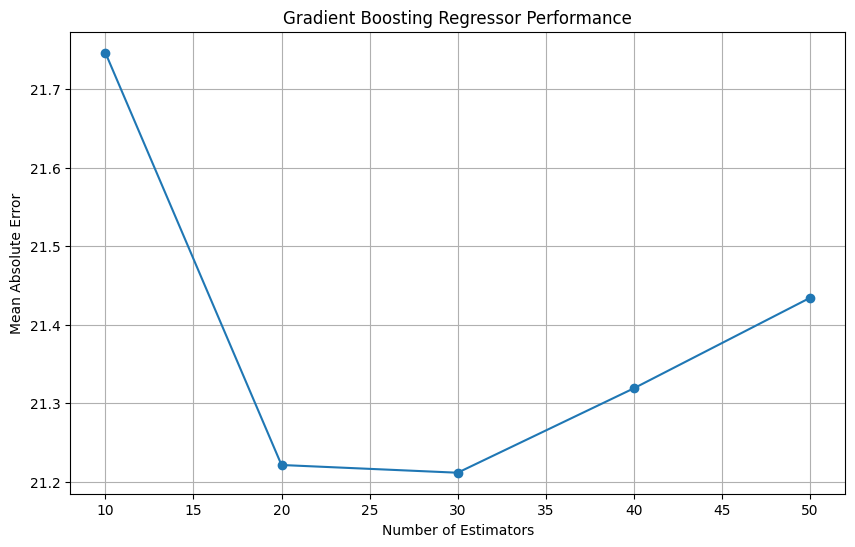

n_estimators=10: Mean Absolute Error=21.746541998959767
Model parameters:
{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_iter_no_change': None, 'random_state': 0, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
--------------------------------------------------
n_estimators=20: Mean Absolute Error=21.221463811711146
Model parameters:
{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_iter_no_change': None, 'ran

In [ ]:
#Define the number of estimators (trees) to try
n_estimators_list = [10, 20, 30, 40, 50]

#Initialize an empty list to store all models and their performance
models = []
total_scores = []

#Splitting the data into training and testing sets
X_train_part, X_test_part, y_train_part, y_test_part = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

for n_estimators in n_estimators_list:
    #Initialize the GradientBoostingRegressor with the current number of estimators
    regressor = GradientBoostingRegressor(n_estimators=n_estimators, random_state=0)

    #Train the model on the training data
    regressor.fit(X_train_part, y_train_part)

    #Predict using the testing data
    y_pred = regressor.predict(X_test_part)

    #Evaluate the model using mean absolute error (MAE)
    mae = mean_absolute_error(y_test_part, y_pred)

    #Append the model and its performance to the lists
    models.append(regressor)
    total_scores.append(mae)

#Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, total_scores, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Absolute Error')
plt.title('Gradient Boosting Regressor Performance')
plt.grid(True)
plt.show()

#Optionally, print the results including all parameters
for i, n_estimators in enumerate(n_estimators_list):
    print(f"n_estimators={n_estimators}: Mean Absolute Error={total_scores[i]}")
    print("Model parameters:")
    print(models[i].get_params())
    print("-" * 50)


Paradójicamente no se ha podido encontrar un mejor resultado usando la optimización parámetros conformada por Random Search y Grid Search. Por lo que se ha optado por usar los resultados de esta ejecución inicial. Se descarga el archivo de predicciones para n_estimators = 30:

In [ ]:
#Crear el modelo con los mejores parámetros encontrados
regressor = GradientBoostingRegressor(n_estimators=30, random_state=0)

#Ajustar el modelo con los datos de entrenamiento completos
regressor.fit(X_train, y_train)

#Realizar predicciones en el conjunto de prueba
y_pred = regressor.predict(X_test)
red(y_pred)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded practica2_pred_20240710153151.csv


## Regresión de Ridge

**Nombre del modelo:** RR \
**Referencia:** https://cienciadedatos.net/documentos/py14-ridge-lasso-elastic-net-python

Dado que la regresión lineal ha dado buenos resultados, se intentará corregir parte del sobreajuste para obtener una mejor predicción. Se ha elegido la regularización Ridge, que reduce proporcionalmente el valor de todos los coeficientes del modelo sin llegar a cero. El grado de penalización está controlado por el hiperparámetro alpha. Mediante un Grid Search, se buscará la mejor optimización de este valor. Los datasets se normalizan nuevamente:

In [ ]:
scaler = MinMaxScaler()
X_train = train4[selected_features]
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(test3[selected_features])
y_train = train4['total_cases']

**Optimización de hiperparámetros**

**Grid Search**

In [ ]:
#Definir el modelo
ridge_regressor = Ridge()

#Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'alpha': [1,2,3,4,5,6,7,8],  #Valores específicos para el parámetro de regularización alpha
}

#Configurar Grid Search con MAE como métrica de evaluación
grid_search = GridSearchCV(
    estimator=ridge_regressor,
    param_grid=param_grid,
    cv=5,  #Número de folds en la validación cruzada
    scoring='neg_mean_absolute_error',  #Métrica para evaluar (MAE)
    n_jobs=-1  #Usar todos los núcleos disponibles
)

#Ajustar el modelo
grid_search.fit(X_train, y_train)

#Mejor combinación de parámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)
print("Mejor puntuación obtenida (neg_mean_absolute_error):", grid_search.best_score_)


Mejores parámetros encontrados: {'alpha': 2}
Mejor puntuación obtenida (neg_mean_absolute_error): -22.663531072462696


Se descargan los resultados para la mejor parametrización:

In [ ]:
y_pred = grid_search.predict(X_test)
red(y_pred)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded practica2_pred_20240710171723.csv


---
# Conclusiones
---

Se presentan los resultados en la tabla con el formato adecuado:

| Modelo | MAE test (DrivenData) | MAE validación | Algoritmo | Hiperparámetros | Descripción
| --- | --- | --- | --- | --- | --- |
| Ejemplo-RL | 27,2524| NO | Regresión lineal | NO | Algoritmo de ejemplo
| KNN | 27,550 | 21.9103 | K-Nearest Neighbors | metric = euclidean; n_neighbors = 62; weights = distance | Algoritmo básico de regresión basado en vecinos cercanos
| AD | 26,7716 | 20.9725 | Árboles de decisión | max_depth = 3; max_features = sqrt; min_samples_leaf = 13; min_samples_split = 8 | Algoritmo basado en estructuras jerárquicas
| CM-RF | 28,9663 | 22.3295 | Random forest | max_depth = 18; max_features = log2; min_samples_leaf = 18; min_samples_split = 2; n_estimators = 256 | Modelo derivado de los árboles de decisión (promedia resultados)
| GB | 28,0240 | 21.2116 | Gradient boost | n_estimators = 30 | Modelo derivado de los árboles de decisión (combinación secuencial)
| RR | 27,2620 | 22.6635 | Regresión lineal Ridge | alpha = 2 | Mejora de la regresión lineal, evitando el sobreajuste


En este trabajo han ido apareciendo una serie de problemáticas que poco a poco han ido resolviéndose. Paradójicamente los modelos simples han obtenido mejores resultados que los considerados más complejos, esto puede deberse a varios factores:

*   Selección de características: la elección de características no ha sido ni mucho menos la más óptima. Estaría bien utilizar otros métodos de seleccion que constrasten los resultados obtenidos. Otra buena estrategia sería la combinación de variables, sin quedarse únicamente con una representativa de cada agrupamiento.
*   Sensibilidad a los hiperparámetros: la optimización de los hiperparámetros ha supuesto una gran complejidad debido a los problemas de rendimiento de los modelos. No se ha conseguido exprimir de manera adecuada los resultados. Esto se puede ver en el ejemplo del modelo AD con el CM-RF y GB, ya que se supone que estos dos últimos debían dar mejores resultados.
*   Falta de datos: el dataset no presenta una cantidad de instancias suficiente para conseguir unos resultados favorables. En una situación real, sería conveniente conseguir una mayor cantidad de mediciones.

En estos puntos se pueden ver muchos aspectos de mejora de los algoritmos actuales. Claramente CM-RF y GB deberían de dar mejores resultados, pero debido a las técnicas usadas no se ha dispuesto del sufiente tiempo para calcular los mejores hiperparámetros. Se deberían de estudiar métodos más avanzados para usar a futuro. Además, el modelo RR no ha supuesto una mejora en la regresión lineal inicial, algo que hace plantear si el aumento de la complejidad de los algoritmos es mejor en todos los casos o más bien depende de las características del problema.

Por lo que finalmente, el modelo final elegido es:


**Modelo final elegido**
* Nombre/Identificador: AD
* MAE test (DrivenData): 	26,7716
* MAE validación: 20.9725
* Algoritmo ML: Árboles de decisión
* Hiperparámetros: max_depth = 3; max_features = sqrt; min_samples_leaf = 13; min_samples_split = 8
* Lista de características: station_diur_temp_rng_c, station_avg_temp_c, precipitation_amt_mm, station_precip_mm, reanalysis_relative_humidity_percent y station_min_temp_c
* Resumen del dataset (transformaciones aplicadas, etc.): se han usado las características elegidas en el apartado correspondiente. En cuanto a la optimización de hiperparámetros, se han aplicado dos técnicas: 1. Random Search para tener una estimación inicial y 2. Grid Search para afinar los resultados. Se ha intentado manejar de mejor manera el sobreajuste, usando validación cruzada.

---
# Competición
---

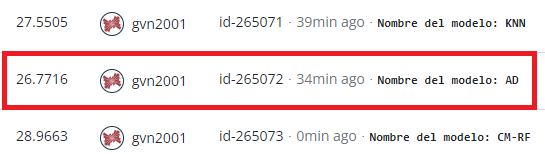

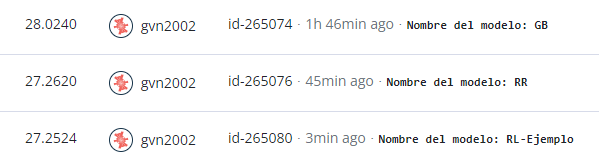